In [4]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath('..'))
# project_root = os.path.dirname(os.path.dirname(os.path.abspath('..')))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [6]:
import torch
from pathlib import Path
from src.utils.dataset_dev import load_wandb_model, dataloader_from_wandb_cfg, data_from_loader

# Load model and dataset
run_id = 'e51hcsb9'
model, cfg = load_wandb_model(run=run_id, name='epoch=57.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../train/config.yaml',
                              wandb_cache_path='/cephfs/store/gr-mc2473/lc865/wandb_cache')
# /cephfs/store/gr-mc2473/lc865/wandb_cache

/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
Fontconfig error: Cannot load default config file: No such file: (null)
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste

dict_keys(['encoder.mlp.net.0.weight', 'encoder.mlp.net.0.bias', 'encoder.mlp.net.2.weight', 'encoder.mlp.net.2.bias', 'encoder.mlp.net.2.running_mean', 'encoder.mlp.net.2.running_var', 'encoder.mlp.net.2.num_batches_tracked', 'encoder.mlp.net.3.block.0.weight', 'encoder.mlp.net.3.block.0.bias', 'encoder.mlp.net.3.block.2.weight', 'encoder.mlp.net.3.block.2.bias', 'encoder.mlp.net.3.block.2.running_mean', 'encoder.mlp.net.3.block.2.running_var', 'encoder.mlp.net.3.block.2.num_batches_tracked', 'encoder.mlp.net.3.block.3.weight', 'encoder.mlp.net.3.block.3.bias', 'encoder.mlp.net.3.block.5.weight', 'encoder.mlp.net.3.block.5.bias', 'encoder.mlp.net.3.block.5.running_mean', 'encoder.mlp.net.3.block.5.running_var', 'encoder.mlp.net.3.block.5.num_batches_tracked', 'encoder.mlp.net.4.block.0.weight', 'encoder.mlp.net.4.block.0.bias', 'encoder.mlp.net.4.block.2.weight', 'encoder.mlp.net.4.block.2.bias', 'encoder.mlp.net.4.block.2.running_mean', 'encoder.mlp.net.4.block.2.running_var', 'encod

In [7]:
batch_size = 1
syntax_shape = (batch_size, cfg.model.io_format.seq_len, cfg.model.io_format.token_cnt)
x = torch.zeros(syntax_shape, dtype=torch.float32)
sample_eps = 1e-3
sample_count = 8
input = {
    'input_sample': x,
    'sample_eps': sample_eps,
    'sample_count': sample_count
}

In [9]:
fpath = f'./onnx-models/model-{run_id}.onnx'
print(os.path.abspath(fpath))

/cephfs/home/lc865/workspace/similar-expressions/src/ONNX_conversion/onnx-models/model-e51hcsb9.onnx


In [ ]:
fpath = Path(f'./onnx-models/model-{run_id}.onnx')
if not fpath.exists():  # Make sure we don't overwrite files
    if not fpath.parent.exists():
        fpath.parent.mkdir(parents=True, exist_ok=True)
    model.to_onnx(fpath, tuple(input.values()), export_params=True)

## 2. Load model via ONNX

In [13]:
train_loader, valid_loader, info = dataloader_from_wandb_cfg(
    cfg, 
    datapath='/cephfs/store/gr-mc2473/lc865/workspace/data/',
    max_length=1000, 
    allow_different_dataset_hash=True
)
input_arr = data_from_loader(train_loader, 'x', idx=0).detach().numpy()

Using dataset "dataset_250110_2" of size 900
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 900     | Batch: 512   | Batches: 1    
  | valid        | Size: 100     | Batch: 512   | Batches: 0    
---------------------------------------------------------------------


In [25]:
import onnxruntime
import numpy as np

sample_eps, sample_count = 1e-1, 16

ort_session = onnxruntime.InferenceSession(fpath)
ort_inputs = {
    ort_session.get_inputs()[0].name: input_arr, 
    ort_session.get_inputs()[1].name: np.array([sample_eps], dtype=np.float64),
    ort_session.get_inputs()[2].name: np.array([sample_count], dtype=np.int64)
}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(16, 15, 12)

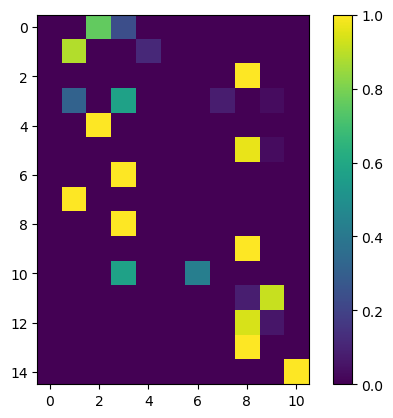

In [24]:
from matplotlib import pyplot as plt

i = 6
plt.imshow(torch.tensor(ort_outs[0][i].squeeze()[:, :-1]).softmax(dim=-1).detach().numpy())
plt.colorbar()
plt.show()